## Predicting NBA Game Outcomes Using Team Stats

In [1]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [234]:
# imports

# player stats by game
original_data = pd.read_excel("data/Lakers-Timbers 2023-12-23.xlsx")
original_data.head()

# T1 stats
T1 = 'Lakers'
team_ppg1 = 114
team_ppg1_rank = 17
opp_ppg1 = 114.2
opp_ppg1_rank = 16 

# T2 stats
T2 = 'Timberwolves'
team_ppg2 = 113.5
team_ppg2_rank = 18
opp_ppg2 = 106.6
opp_ppg2_rank = 1

# location stats
home_team = T2
home_team_wr = 12/13
away_team = T1
away_team_wr = 6/17

# dictionary with team stats
team_stats = {
    T1: {
        'team_ppg': team_ppg1,
        'opp_ppg': opp_ppg1,
        'team_ppg_rank': team_ppg1_rank,
        'opp_ppg_rank': opp_ppg1_rank,
    },
    T2: {
        'team_ppg': team_ppg2,
        'opp_ppg': opp_ppg2,
        'team_ppg_rank': team_ppg2_rank,
        'opp_ppg_rank': opp_ppg2_rank,
    },
}

team_stats

{'Lakers': {'team_ppg': 114,
  'opp_ppg': 114.2,
  'team_ppg_rank': 17,
  'opp_ppg_rank': 16},
 'Timberwolves': {'team_ppg': 113.5,
  'opp_ppg': 106.6,
  'team_ppg_rank': 18,
  'opp_ppg_rank': 1}}

In [232]:
# shape excel sheet for player stats

# create a new column for total play time
original_data['PLAY'] = original_data['GP'] * original_data['MIN']

# sort by team name, then by total time played
sorted_df = original_data.sort_values(by=['Team', 'PLAY'], ascending=[True, False])

# map team stats to the sorted DataFrame
sorted_df['team_ppg'] = sorted_df['Team'].map(lambda team: team_stats[team]['team_ppg'])
sorted_df['opp_ppg'] = sorted_df['Team'].map(lambda team: team_stats[team]['opp_ppg'])

# print all columns in sorted_df for selection
print(sorted_df.columns)

Index(['PLAYERS', 'Team', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
       'STL', 'BLK', 'PF', '+/-', 'GP.1', 'MIN.1', 'OFFRTG', 'DEFRTG',
       'NETRTG', 'AST%', 'AST/TO', 'AST RATIO', 'OREB%', 'DREB%', 'REB%',
       'TOV%', 'EFG%', 'TS%', 'USG%', 'PACE', 'PIE', 'PLAY', 'team_ppg',
       'opp_ppg'],
      dtype='object')


### Offensive Rating

In [182]:
# new dataframe for offensive evaluation
offensive_df = sorted_df[['PLAYERS', 'Team', 'PLAY', 'PTS', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'AST', 'TOV', 'PF', 'OFFRTG', 'team_ppg']]

# create new columns for missed field goals, missed 3-pointers, and missed free throws
offensive_df['Missed_FG'] = offensive_df['FGA'] - offensive_df['FGM']
offensive_df['Missed_3P'] = offensive_df['3PA'] - offensive_df['3PM']
offensive_df['Missed_FT'] = offensive_df['FTA'] - offensive_df['FTM']

# drop the original columns
offensive_df.drop(['FGA', '3PA', 'FTA'], axis=1, inplace=True)

# weights for each column
# 1.0 for anything equivalent to contributing to offensive rating
weights_offensive = {
    'PTS': 1.0,
    'FGM': 0.5,  # more made field goals contribute positively to offensive rating
    'Missed_FG': -0.3,  # more missed field goals contribute negatively to offensive rating
    '3PM': 0.7,  # more made three-pointers contribute positively to offensive rating
    'Missed_3P': -0.4,  # more missed three-pointers contribute negatively to offensive rating
    'FTM': 0.2,  # more made free throws contribute positively to offensive rating
    'Missed_FT': -0.2,  # more missed free throws contribute negatively to offensive rating
    'OREB': 0.75,  # more offensive rebounds contribute positively to offensive rating
    'AST': 1.0,  # more assists contribute positively to offensive rating
    'TOV': -1.0,  # more turnovers contribute negatively to offensive rating
    'PF': -1.25,  # more personal fouls contribute negatively to offensive rating
    'OFFRTG': 0.25,  # higher offensive rating contributes positively to offensive rating
    'team_ppg': 0.5,  # team points per game also contribute positively to offensive rating
}

# apply weights to columns
weighted_columns_offensive = offensive_df[['PTS', 'FGM', 'Missed_FG', '3PM', 'Missed_3P', 'FTM', 'Missed_FT', 'OREB', 'AST', 'TOV', 'PF', 'OFFRTG', 'team_ppg']].multiply(weights_offensive)
offensive_df['Weighted_Score'] = weighted_columns_offensive.sum(axis=1)

# multiply by 'PLAY' column
offensive_df['Weighted_Score'] = offensive_df['Weighted_Score'] * offensive_df['PLAY']

# calculating a team offensive rating using player ratings and amount of time played
team1_offensive_score = offensive_df[offensive_df['Team'] == T1]['Weighted_Score'].sum() / offensive_df[offensive_df['Team'] == T1]['PLAY'].sum()
team2_offensive_score = offensive_df[offensive_df['Team'] == T2]['Weighted_Score'].sum() / offensive_df[offensive_df['Team'] == T2]['PLAY'].sum()

# display the team offensive scores
print(f"The {T1} offensive rating: {team1_offensive_score}")
print(f"The {T2} offensive rating: {team2_offensive_score}")

# compare offensive scores
if team1_offensive_score > team2_offensive_score:
    better_offensive_team = T1
    worse_offensive_team = T2
    percentage_difference_offensive = ((team1_offensive_score - team2_offensive_score) / team2_offensive_score) * 100
else:
    better_offensive_team = T2
    worse_offensive_team = T1
    percentage_difference_offensive = ((team2_offensive_score - team1_offensive_score) / team1_offensive_score) * 100

# print offensive results
print(f"The {better_offensive_team} offensive rating is {abs(percentage_difference_offensive):.2f}% better than {worse_offensive_team}")

The Lakers offensive rating: 99.85672295996234
The Timberwolves offensive rating: 98.95061137754004
The Lakers offensive rating is 0.92% better than Timberwolves


/var/folders/bl/bhy6kgn16kx9r1j535zcctcw0000gn/T/ipykernel_90088/110571356.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offensive_df['Missed_FG'] = offensive_df['FGA'] - offensive_df['FGM']
/var/folders/bl/bhy6kgn16kx9r1j535zcctcw0000gn/T/ipykernel_90088/110571356.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offensive_df['Missed_3P'] = offensive_df['3PA'] - offensive_df['3PM']
/var/folders/bl/bhy6kgn16kx9r1j535zcctcw0000gn/T/ipykernel_90088/110571356.py:7: SettingWithCopyWarning: 
A value is t

### Defensive Rating

In [183]:
# new dataframe for defensive evaluation
defensive_df = sorted_df[['PLAYERS', 'Team', 'PLAY', 'DREB', 'STL', 'BLK', 'PF', 'DEFRTG', 'opp_ppg']]

# weights for each column
# 1.0 for anything equivalent to preventing an opponent score
weights = {
    'DREB': 1.0,
    'STL': 1.0,
    'BLK': 0.5,
    'PF': -1.5,   # fewer Player Fouls is better, so we use a negative weight
    'DEFRTG': 0.25, 
    'opp_ppg': -0.75 # fewer Opponent Points per Game is better, so we use a negative weight
}

# apply weights to columns
weighted_columns = defensive_df[['DREB', 'STL', 'BLK', 'PF', 'DEFRTG', 'opp_ppg']].multiply(weights)
defensive_df['Weighted_Score'] = weighted_columns.sum(axis=1)

# multiply by 'PLAY' column
defensive_df['Weighted_Score'] = defensive_df['Weighted_Score'] * defensive_df['PLAY']

# display the DataFrame with the new Weighted_Score column
defensive_df[['PLAYERS', 'Team', 'Weighted_Score']]

# calculating a team defensive rating using player ratings and amount of time played
team1_defensive_score = defensive_df[defensive_df['Team'] == T1]['Weighted_Score'].sum() / defensive_df[defensive_df['Team'] == T1]['PLAY'].sum()
team2_defensive_score = defensive_df[defensive_df['Team'] == T2]['Weighted_Score'].sum() / defensive_df[defensive_df['Team'] == T2]['PLAY'].sum()

# display the team defensive scores
print(f"The {T1} defensive rating: {team1_defensive_score}")
print(f"The {T2} defensive rating: {team2_defensive_score}")

# compare defensive scores
if team1_defensive_score > team2_defensive_score:
    better_defensive_team = T1
    worse_defensive_team = T2
    percentage_difference_defensive = ((team1_defensive_score - team2_defensive_score) / team2_defensive_score) * 100
else:
    better_defensive_team = T2
    worse_defensive_team = T1
    percentage_difference_defensive = ((team2_defensive_score - team1_defensive_score) / team1_defensive_score) * 100

# print defensive results
print(f"The {better_defensive_team} defensive rating is {abs(percentage_difference_defensive):.2f}% better than {worse_defensive_team}")

The Lakers defensive rating: -55.16814317705289
The Timberwolves defensive rating: -51.226956715546116
The Timberwolves defensive rating is 7.14% better than Lakers


/var/folders/bl/bhy6kgn16kx9r1j535zcctcw0000gn/T/ipykernel_90088/2529480388.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defensive_df['Weighted_Score'] = weighted_columns.sum(axis=1)
/var/folders/bl/bhy6kgn16kx9r1j535zcctcw0000gn/T/ipykernel_90088/2529480388.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defensive_df['Weighted_Score'] = defensive_df['Weighted_Score'] * defensive_df['PLAY']


### Creating a Point of Reference

In [208]:
def calculate_15(team1_stats, team2_stats, team1_score, team2_score, rank_key='opp_ppg_rank'):
    # extract ranks from team stats
    team1_rank = team1_stats.get(rank_key, None)
    team2_rank = team2_stats.get(rank_key, None)
    
    # check if either team is ranked 15th
    if team1_rank == 15 or team2_rank == 15:
        return team1_score, team2_score  # no need to calculate average if one of the teams is already ranked 15th
    
    # calculate the difference in ranks between the two teams
    rank_difference = abs(team1_rank - team2_rank)
    
    # calculate the value of changing one rank
    rank_increment_value = abs(abs(team1_score) - abs(team2_score)) / rank_difference
    
    # calculate the average score of the 15th ranked team for Team 1
    rank_distance = 15 - team1_rank
    if rank_distance < 0:
        average_score = team1_score + rank_increment_value * abs(rank_distance)
    else:
        average_score = team1_score - rank_increment_value * abs(rank_distance)
    
    return average_score

# calculate the estimated average offensive score
average_offensive_rating = calculate_15(T1_stats, T2_stats, team1_offensive_score, team2_offensive_score, rank_key='team_ppg_rank')
print(f"The estimated average offensive rating is {average_offensive_rating:.2f}")

# calculate the estimated average defensive score
average_defensive_rating = calculate_15(T1_stats, T2_stats, team1_defensive_score, team2_defensive_score, rank_key='opp_ppg_rank')
print(f"The estimated average defensive rating is {average_defensive_rating:.2f}")

The estimated average offensive rating is 101.67
The estimated average defensive rating is -54.91


In [213]:
# compare offensive scores for Team 1
if team1_offensive_score > average_offensive_rating:
    print(f"The {T1}'s offensive rating is {abs((team1_offensive_score - average_offensive_rating) / average_offensive_rating) * 100:.2f}% better than the estimated average")
else:
    print(f"The {T1}'s offensive rating is {abs((team1_offensive_score - average_offensive_rating) / average_offensive_rating) * 100:.2f}% worse than the estimated average")

# compare offensive scores for Team 2
if team2_offensive_score > average_offensive_rating:
    print(f"The {T2}'s offensive rating is {abs((team2_offensive_score - average_offensive_rating) / average_offensive_rating) * 100:.2f}% better than the estimated average")
else:
    print(f"The {T2}'s offensive rating is {abs((team2_offensive_score - average_offensive_rating) / average_offensive_rating) * 100:.2f}% worse than the estimated average")

# compare defensive scores for Team 1
if team1_defensive_score > average_defensive_rating:
    print(f"The {T1}'s defensive rating is {abs((team1_defensive_score - average_defensive_rating) / average_defensive_rating) * 100:.2f}% better than the estimated average")
else:
    print(f"The {T1}'s defensive rating is {abs((team1_defensive_score - average_defensive_rating) / average_defensive_rating) * 100:.2f}% worse than the estimated average")

# compare defensive scores for Team 2
if team2_defensive_score > average_defensive_rating:
    print(f"The {T2}'s defensive rating is {abs((team2_defensive_score - average_defensive_rating) / average_defensive_rating) * 100:.2f}% better than the estimated average")
else:
    print(f"The {T2}'s defensive rating is {abs((team2_defensive_score - average_defensive_rating) / average_defensive_rating) * 100:.2f}% worse than the estimated average")

The Lakers's offensive rating is 1.78% worse than the estimated average.
The Timberwolves's offensive rating is 2.67% worse than the estimated average.
The Lakers's defensive rating is 0.48% worse than the estimated average.
The Timberwolves's defensive rating is 6.70% better than the estimated average.


### Combing our Offensive/Deffensive Ratings with our Point of Reference

In [240]:
# estimated distance between T1 offense and T2 defense
T1_disparity = (team1_offensive_score - average_offensive_rating) / average_offensive_rating + (-(team2_defensive_score - average_defensive_rating) / average_defensive_rating)

# estimated distance between T2 offense and T1 defense
T2_disparity = (team2_offensive_score - average_offensive_rating) / average_offensive_rating + (-(team1_defensive_score - average_defensive_rating) / average_defensive_rating)

# calculate each teams score using the differences in off/def ability
T1_score = team_ppg1 * (1 - T1_disparity)
T2_score = team_ppg2 * (1 - T2_disparity)

# adjust scores based on home/away performance with scaling factor
# scaling factor for home/away effect
scaling_factor = 0.1

if home_team == T1:
    T1_score *= (1 + scaling_factor * (home_team_wr - 0.5))
else:
    T2_score *= (1 + scaling_factor * (home_team_wr - 0.5))

if home_team == T2:
    T2_score *= (1 + scaling_factor * (home_team_wr - 0.5))
else:
    T1_score *= (1 + scaling_factor * (home_team_wr - 0.5))

print(f"The {T1} will score {T1_score:.0f} points")
print(f"The {T2} will score {T2_score:.0f} points")

The Lakers will score 108 points
The Timberwolves will score 127 points


### Bootstrapping

Simulated 10000 bootstrap samples:
The Timberwolves have a 98.64% chance to win, with a predicted score of 127 to 108
The Lakers may score between 101 and 115 points (middle 80%)
The Timberwolves may score between 119 and 135 points (middle 80%)


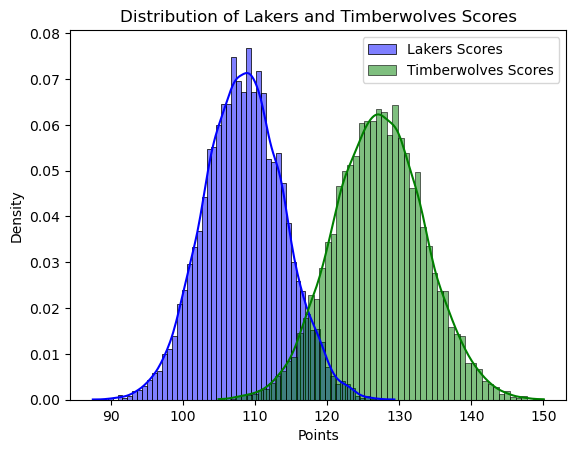

In [271]:
# Number of bootstrap samples
num_samples = 10000

# Mean and standard deviation for the normal distribution
mean_randomization_factor = 1.0
std_dev_randomization_factor = 0.05  # Adjust this to control the spread

# Arrays to store the sampled scores
T1_scores = np.zeros(num_samples)
T2_scores = np.zeros(num_samples)

# Simulate bootstrap samples
for i in range(num_samples):
    # Sample randomization factors from a normal distribution
    randomization_factor_T1 = np.random.normal(mean_randomization_factor, std_dev_randomization_factor)
    randomization_factor_T2 = np.random.normal(mean_randomization_factor, std_dev_randomization_factor)

    # Calculate each team's score using the differences in off/def ability
    T1_score = team_ppg1 * (1 - T1_disparity) * randomization_factor_T1
    T2_score = team_ppg2 * (1 - T2_disparity) * randomization_factor_T2

    # Adjust scores based on home/away performance with scaling factor
    if home_team == T1:
        T1_score *= (1 + scaling_factor * (home_team_wr - 0.5))
    else:
        T2_score *= (1 + scaling_factor * (home_team_wr - 0.5))

    if home_team == T2:
        T2_score *= (1 + scaling_factor * (home_team_wr - 0.5))
    else:
        T1_score *= (1 + scaling_factor * (home_team_wr - 0.5))

    # Store sampled scores
    T1_scores[i] = T1_score
    T2_scores[i] = T2_score

# Calculate win percentages
win_percentage_T1 = np.sum(T1_scores > T2_scores) / num_samples * 100
win_percentage_T2 = np.sum(T2_scores > T1_scores) / num_samples * 100

# Print results
print(f"Simulated {num_samples} bootstrap samples:")

# Print the team with the higher win percentage
if win_percentage_T1 > win_percentage_T2:
    print(f"The {T1} have a {win_percentage_T1:.2f}% chance to win, with a predicted score of {np.mean(T1_scores):.0f} to {np.mean(T2_scores):.0f}")
else:
    print(f"The {T2} have a {win_percentage_T2:.2f}% chance to win, with a predicted score of {np.mean(T2_scores):.0f} to {np.mean(T1_scores):.0f}")


# Calculate the lower and upper bounds for the middle 80%
lower_bound_T1 = np.percentile(T1_scores, 10)
upper_bound_T1 = np.percentile(T1_scores, 90)

lower_bound_T2 = np.percentile(T2_scores, 10)
upper_bound_T2 = np.percentile(T2_scores, 90)

# Print the range of scores
print(f"The {T1} may score between {lower_bound_T1:.0f} and {upper_bound_T1:.0f} points (middle 80%)")
print(f"The {T2} may score between {lower_bound_T2:.0f} and {upper_bound_T2:.0f} points (middle 80%)")


# plot side-by-side bell curves for T1 and T2 scores
sns.histplot(T1_scores, kde=True, stat="density", color="blue", label=f"{T1} Scores")
sns.histplot(T2_scores, kde=True, stat="density", color="green", label=f"{T2} Scores")
plt.title(f"Distribution of {T1} and {T2} Scores")
plt.xlabel("Points")
plt.ylabel("Density")
plt.legend()
plt.show()